## 9.4 Interpreting what convnets learn

most accessible and useful ones:
- Visualizing intermediate convnet outputs (intermediate activations)—Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters
- Visualizing convnet filters—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to
- Visualizing heatmaps of class activation in an image—Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images

### 9.4.1 Visualizing intermediate activations

Visualizing intermediate activations consists of displaying the values returned by various convolution and pooling layers in a model, given a certain input

We want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

In [1]:
from tensorflow import keras
model = keras.models.load_model(
	"convnet_from_scratch_with_augmentation.keras"
)
model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

Next, we’ll get an input image—a picture of a cat, not part of the images the network was trained on.

In [2]:
import numpy as np

img_path = keras.utils.get_file(
	"cat.jpg",
	origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)

def get_img_array(img_path, target_size=(180, 180)):
	img = keras.utils.load_img(
		img_path, target_size=target_size
	)
	#turn the image into a float32 numpy
	# array of shape (180, 180, 3)
	array = keras.utils.img_to_array(img)
	array = np.expand_dims(array, axis=0)
	return array

img_tensor = get_img_array(img_path)
img_tensor.shape

80329/80329 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step


(1, 180, 180, 3)

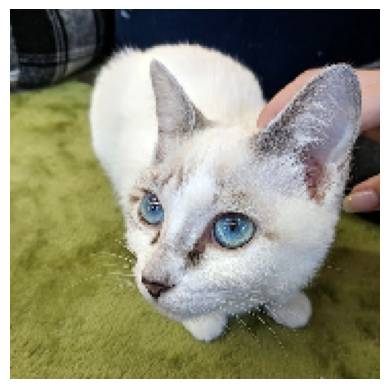

In [3]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

from tensorflow import keras



In order to extract the feature maps we want to look at, we’ll create a Keras model that takes batches of images as input, and that outputs the activations of all convolution and pooling layers.

Listing 9.8 Instantiating a model that returns layer activations

In [4]:
from keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
	if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
		layer_outputs.append(layer.output)
		layer_names.append(layer.name)

activation_model = keras.models.Model(
	inputs=model.input, outputs=layer_outputs
)

When fed an image input, this model returns the values of the layer activations in the original model, as a list. This is the first time you’ve encountered a multi-output model in this book in practice since you learned about them in chapter 7; until now, the models you’ve seen have had exactly one input and one output. This one has one input and nine outputs: one output per layer activation.

### Listing 9.9 Using the model to compute layer activations

In [5]:
#return a list of nine numpy arrays, one array per layer activation
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


(1, 178, 178, 32)


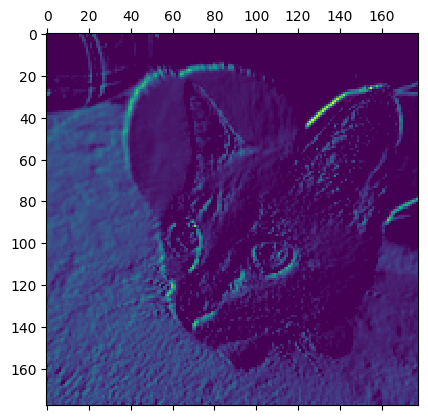

In [11]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap="viridis")
plt.show()

## this was the first channel of the first feature map in the first conv layer

Now, let’s plot a complete visualization of all the activations in the network (see figure 9.14). We’ll extract and plot every channel in each of the layer activations, and we’ll stack the results in one big grid, with channels stacked side by side.

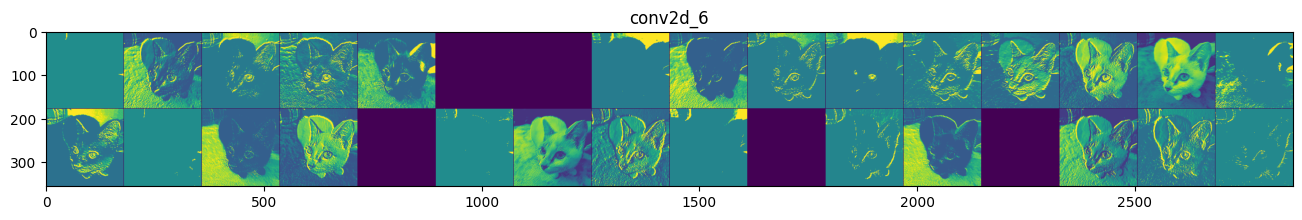

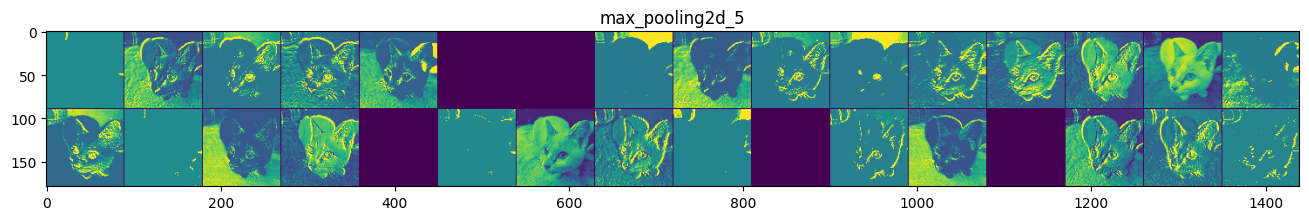

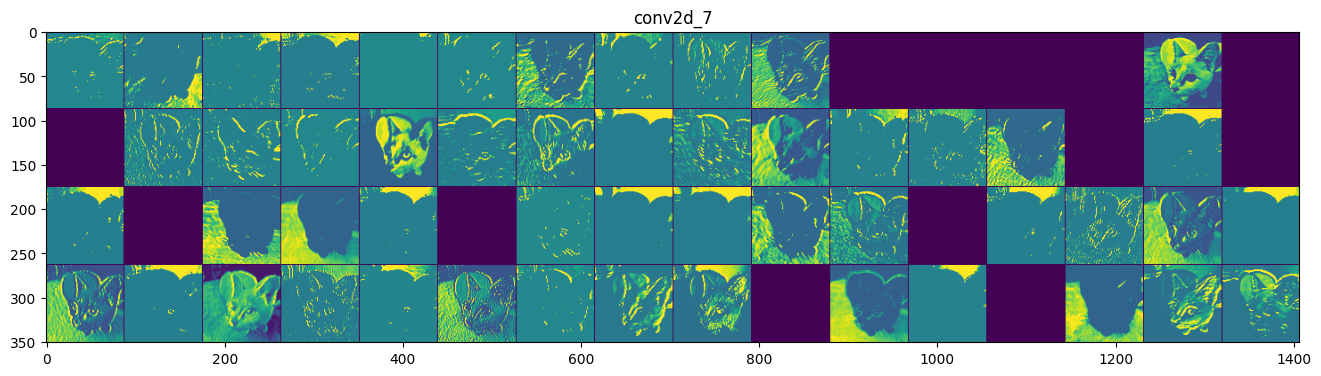

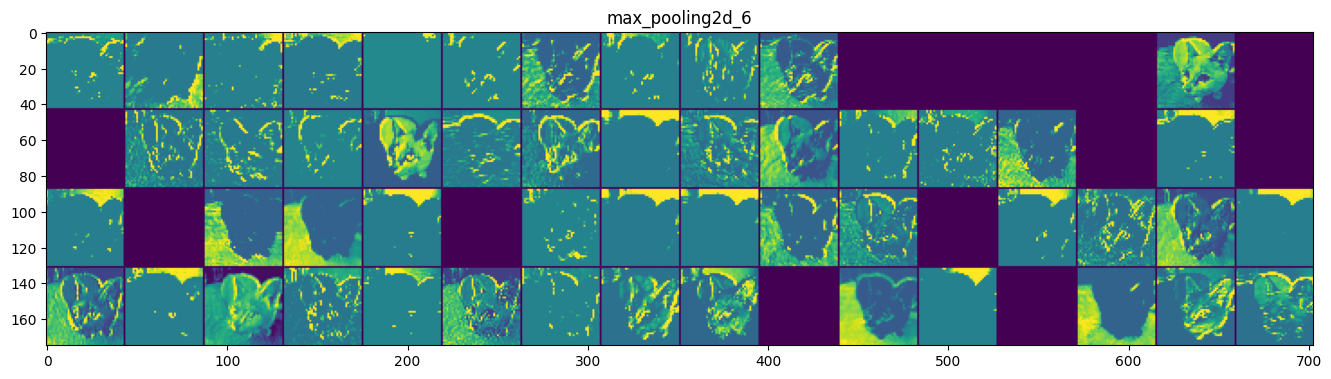

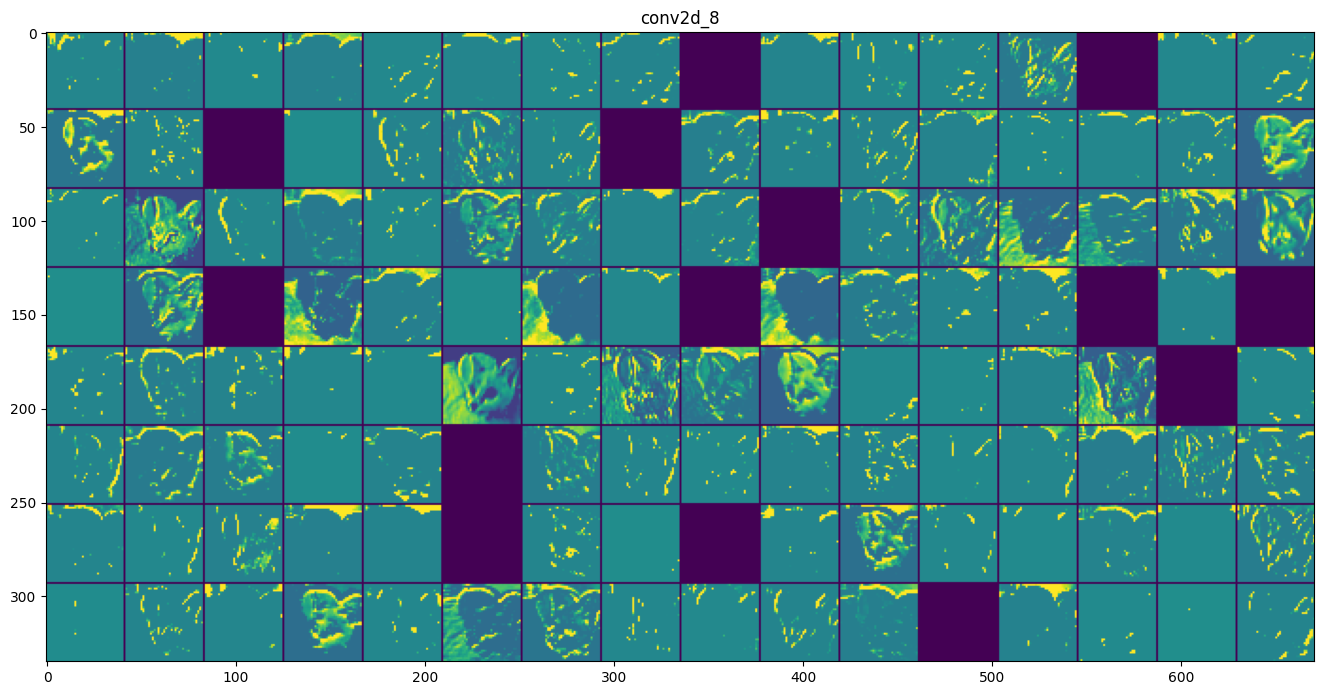

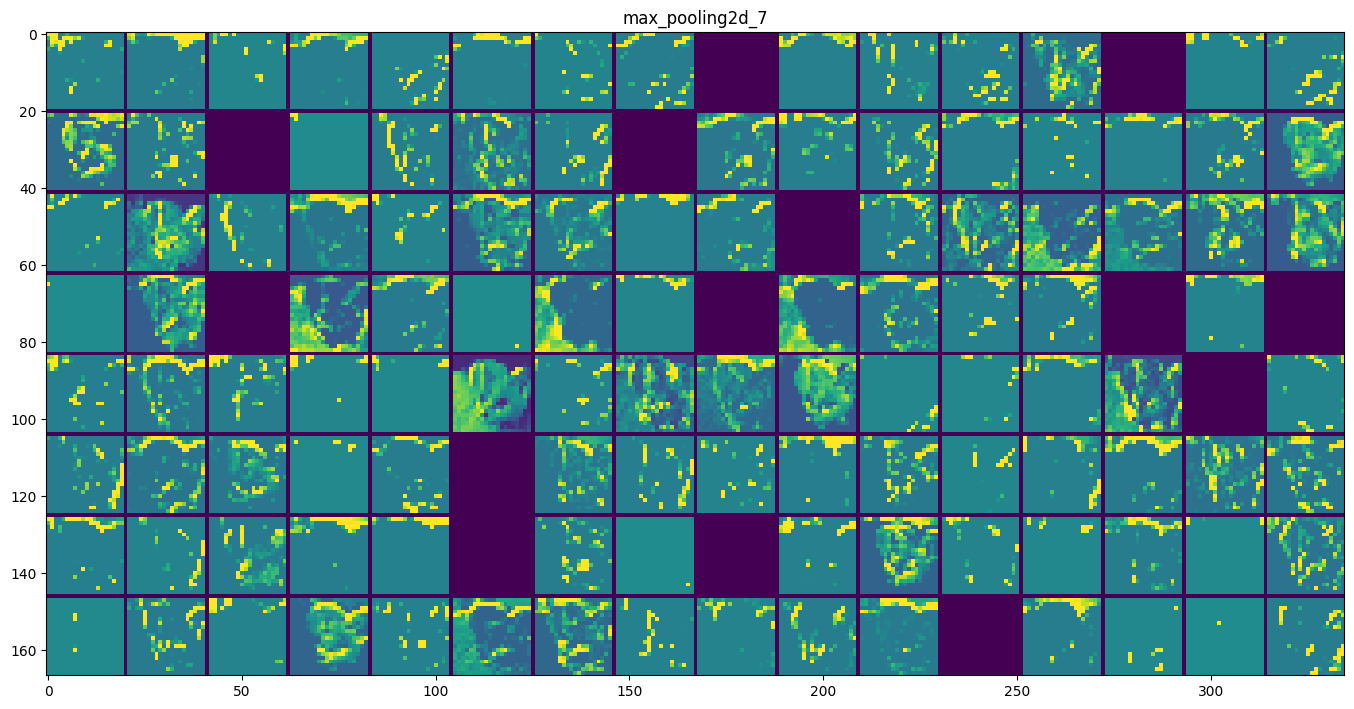

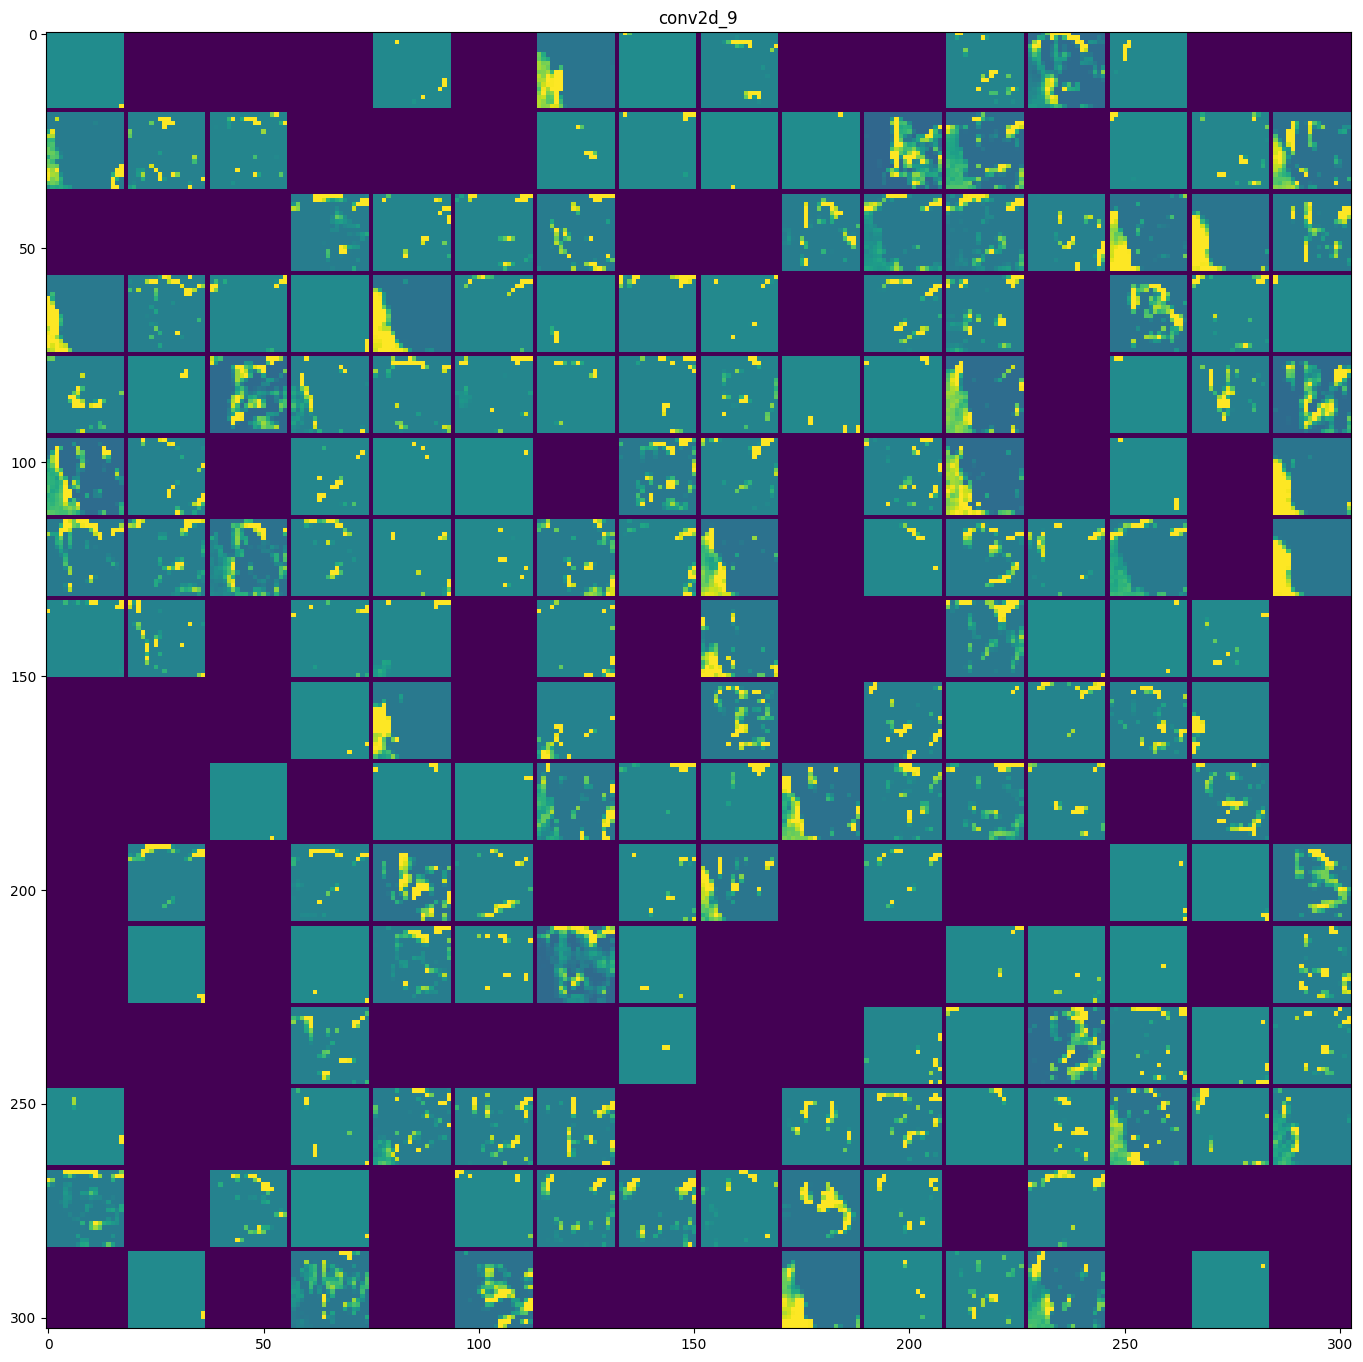

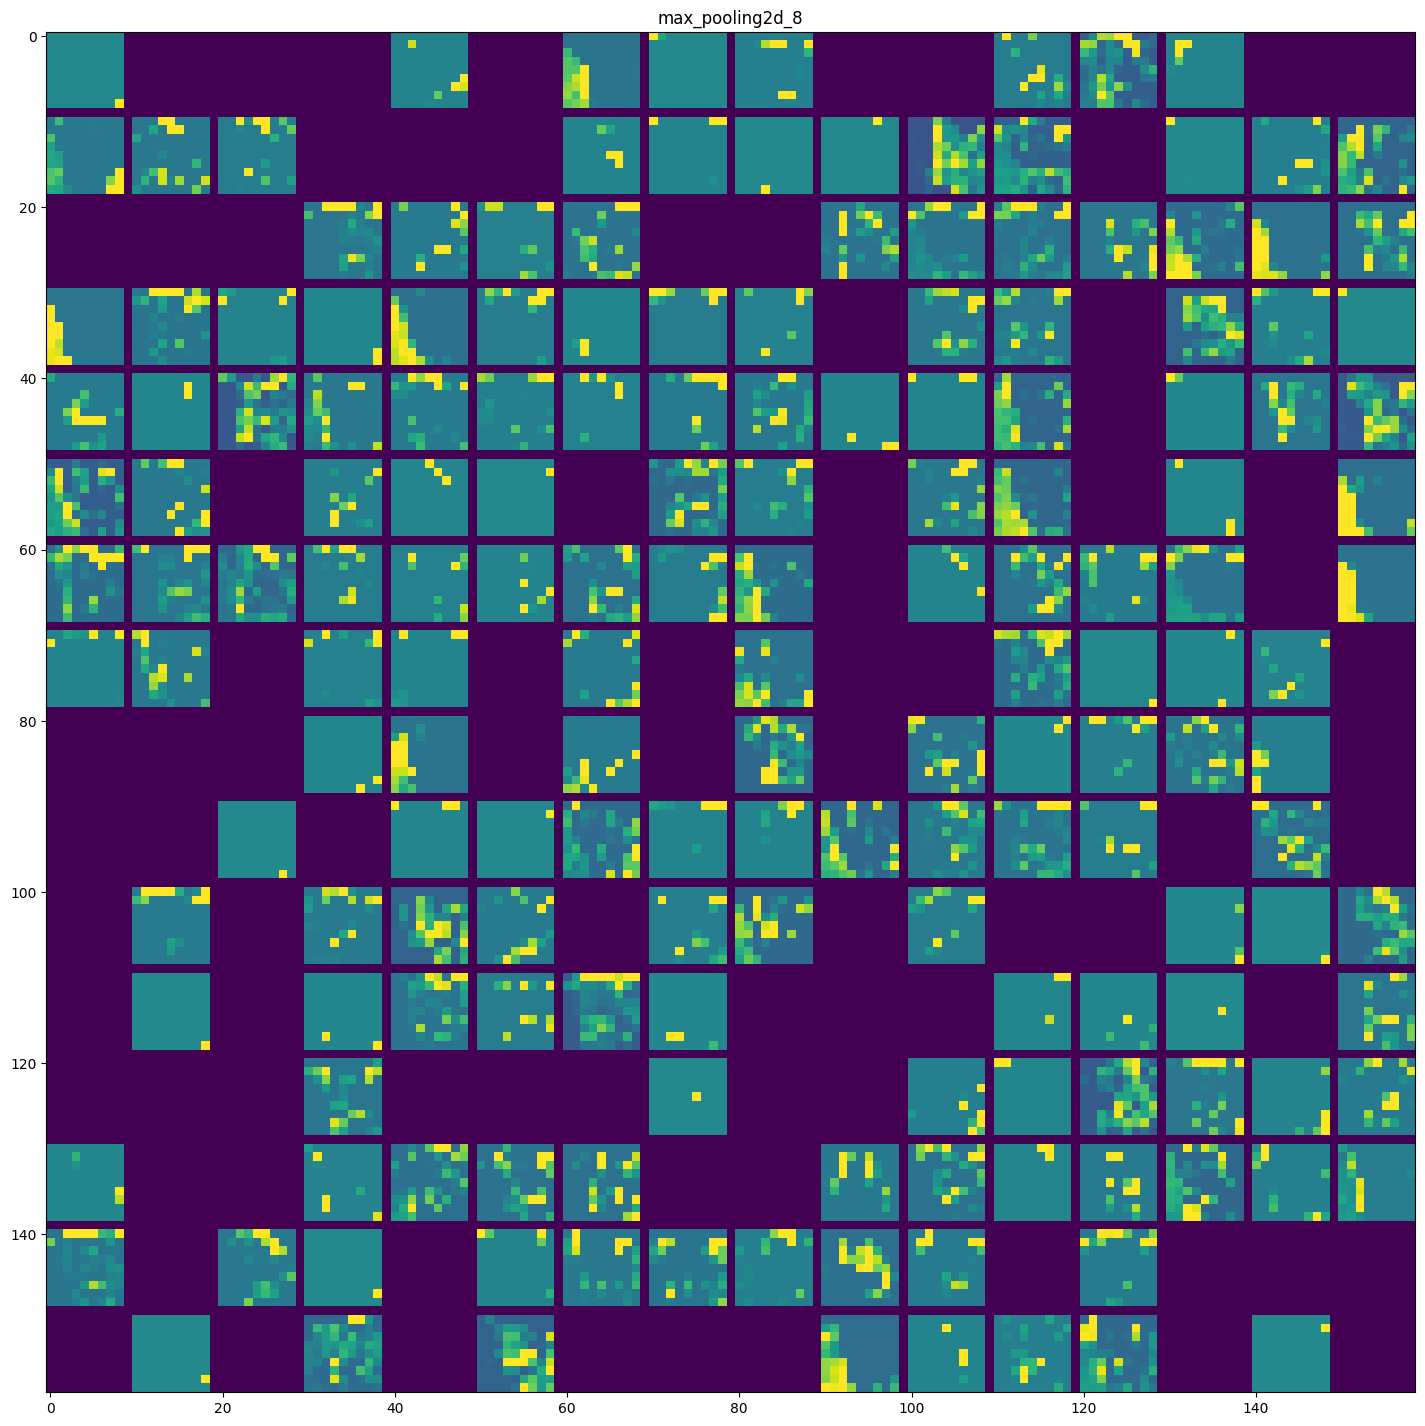

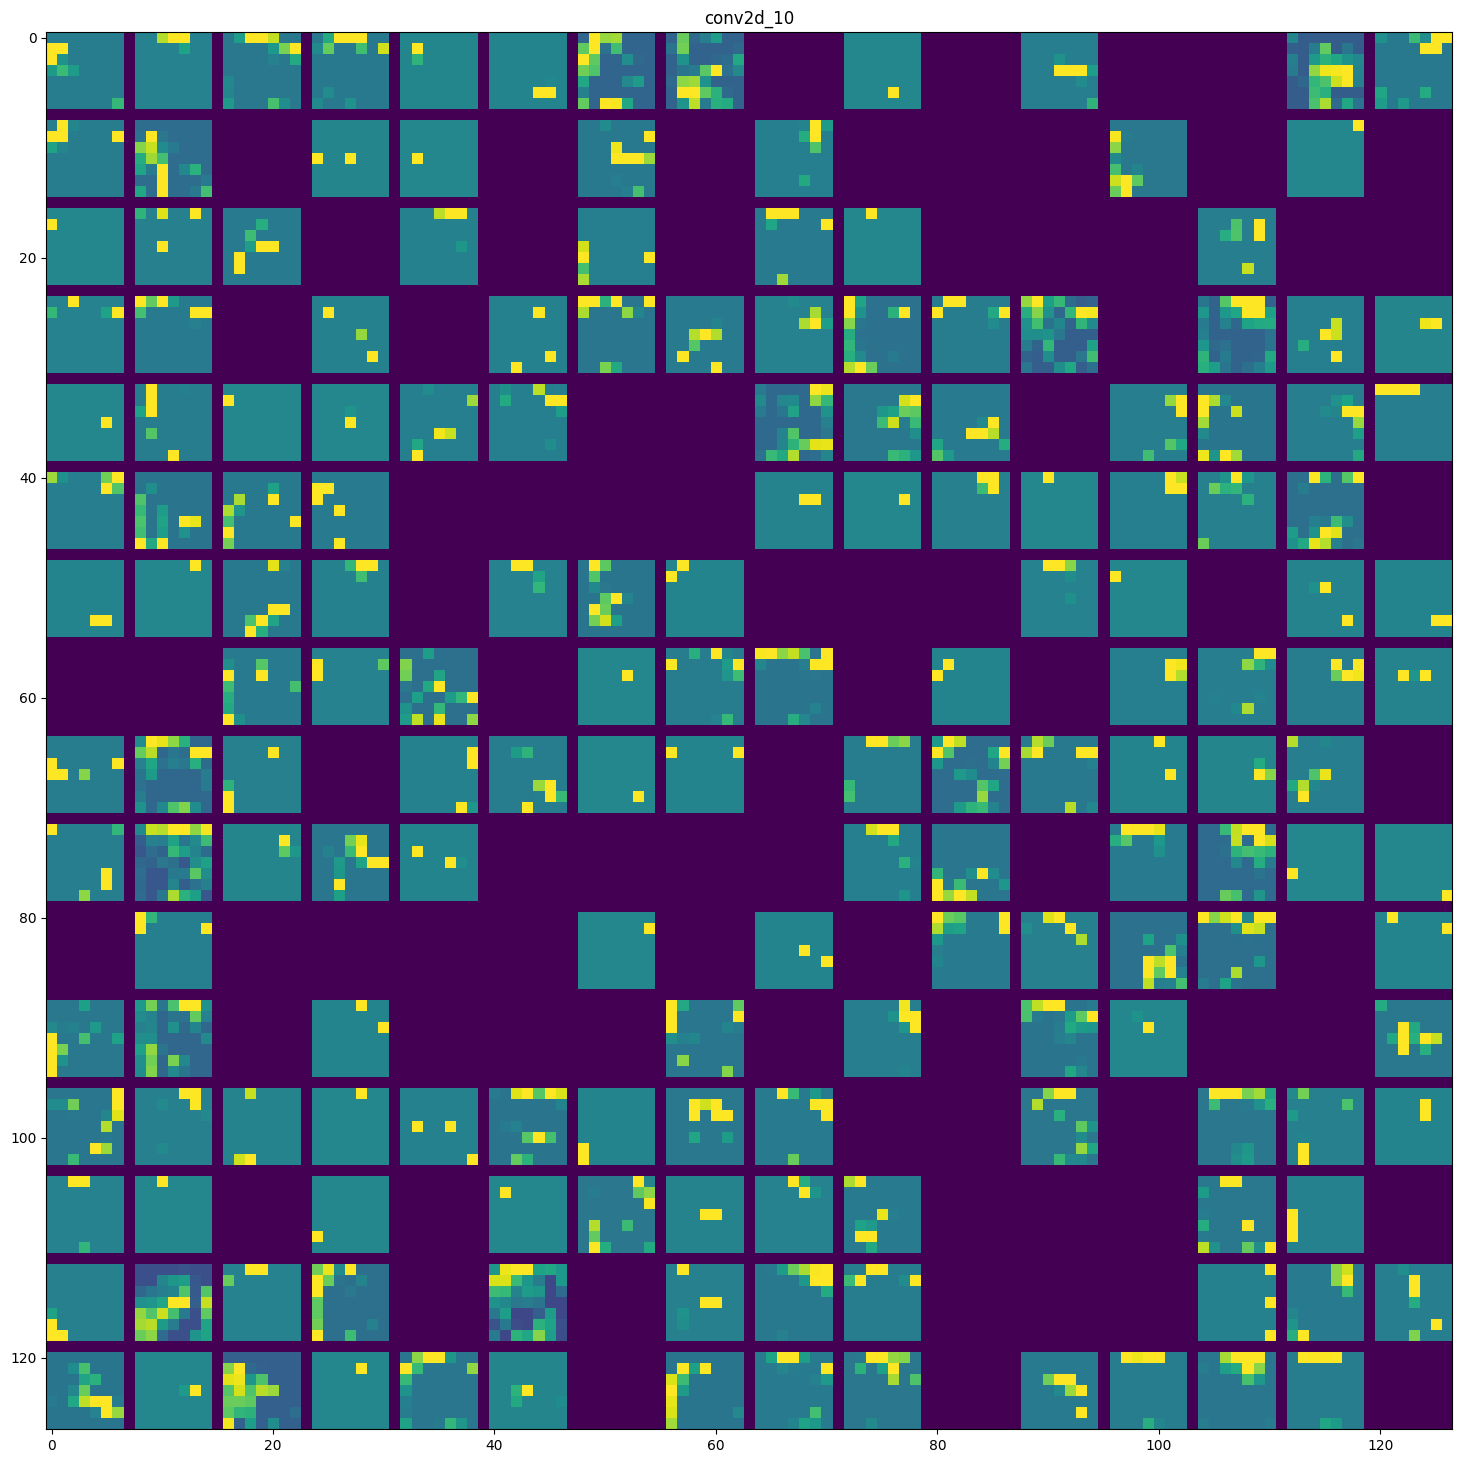

In [16]:
images_per_row = 16

#iterate over the actvatons (and the names of the corresponding layers)
for layer_name, layer_activation in zip(layer_names, activations):
	n_features = layer_activation.shape[-1]
	#the feature map has shape (1, size, size, n_features)
	size = layer_activation.shape[1]
	n_cols = n_features // images_per_row
	#prepare an empty grid for displaying the feature maps
	display_grid = np.zeros(((size+1) * n_cols - 1, images_per_row * (size + 1) - 1))

	for col in range(n_cols):
		for row in range(images_per_row):
			channel_index = col* images_per_row + row
			channel_image = layer_activation[0, :, :, channel_index].copy()
			#normalize channel values within the 0-255 range by using a min-max scale
			if channel_image.sum() != 0:
				channel_image -= channel_image.mean()
				channel_image /= channel_image.std()
				channel_image *= 64
				channel_image += 128
				channel_image = np.clip(channel_image, 0, 255).astype("uint8")
				display_grid[
					#place the channel matrx n the empty grid
					col * (size + 1) : (col + 1) * size + col,
					row * (size + 1) : (row + 1) * size + row] = channel_image
	scale = 1./size
	plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
	plt.title(layer_name)
	plt.grid(False)
	plt.imshow(display_grid, aspect="auto", cmap="viridis")
	plt.show()







### There are a few things to note here:
- the frst layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
- As you go deeper, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Deeper presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image
- The sparsity of the activations increases with the depth of the layer: in the first layer, almost all filters are activated by the input image, but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

## 9.4.2 Visualizing convnet filters

Another easy way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.

Let’s try this with the filters of the Xception model, pretrained on ImageNet. The process is simple: we’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then we’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. This will be our second example of a low-level gradient descent loop leveraging the GradientTape object

In [19]:
#instantiate the Xception model
model = keras.applications.xception.Xception(
	weights="imagenet",
	include_top=False,#the classification head is removed for this use case
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


We’re interested in the convolutional layers of the model—the Conv2D and SeparableConv2D layers. We’ll need to know their names so we can retrieve their outputs. Let’s print their names, in order of depth.

In [20]:
for layer in model.layers:
	if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
		print(layer.name)

#You’ll notice that the SeparableConv2D layers here are all
#  named something like block6_sepconv1, block7_sepconv2, etc
# . Xception is structured into blocks, each containing several convolutional layers.

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


Now, let’s create a second model that returns the output of a specific layer—a feature extractor model. Because our model is a Functional API model, it is inspectable: we can query the output of one of its layers and reuse it in a new model. No need to copy the entire Xception code

In [21]:
#we can use any layer n the Xception model
layer_name = "block3_sepconv1"
#this is the layer object were interested
layer = model.get_layer(name=layer_name)

feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

To use this model, simply call it on some input data (note that Xception requires inputs to be preprocessed via the keras.applications.xception.preprocess_input function).

In [22]:
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

c:\Users\ryanz\estudo-ufal\dl\DeepLearningWithPython\env\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_34']
Received: inputs=Tensor(shape=(1, 180, 180, 3))
  warnings.warn(msg)


Let’s use our feature extractor model to define a function that returns a scalar value quantifying how much a given input image “activates” a given filter in the layer. This is the “loss function” that we’ll maximize during the gradient ascent process:

In [ ]:
import tensorflow as tf

def compute_loss(input_image, filter_index):
	#The loss function takes an image  tensor and the index
	# of the filter  we are considering (an integer).
	activation = feature_extractor(input_image)
	#we avoid border artifacts by only involving non-border pixels in the loss
	filter_activation = activation[:, 2:-2, 2:-2, filter_index]
	#return the mean of the activation values for the filter
	return tf.reduce_mean(filter_activation)


predict() loops over the data in batches (in fact, you can specify the batch size via predict(x, batch_size=64)), and it extracts the NumPy value of the outputs.

This means that predict() calls can scale to very large arrays. Meanwhile, model(x) happens in-memory and doesn’t scale. On the other hand, predict() is not differentiable: you cannot retrieve its gradient if you call it in a GradientTape scope.  You should use model(x) when you need to retrieve the gradients of the model call, and you should use predict() if you just need the output value. In other words, always use predict() unless you’re in the middle of writing a low-level gradient descent loop (as we are now).

## Listing 9.16 Loss maximization via stochastic gradient ascent

In [24]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
	with tf.GradientTape() as tape:
		tape.watch(img)
		#compute the loss ndicating how much the current image activates the filter
		loss = compute_loss(img, filter_index)
	#Compute the gradients  of the loss with respect  to the image
	grads = tape.gradient(loss, img)
	# Apply the “gradient  normalization trick.”
	grads = tf.math.l2_normalize(grads)
	#Move the image a little  bit in a direction that  activates our target  filter more strongly.
	img += learning_rate * grads
	return img

Now we have all the pieces. Let’s put them together into a Python function that takes as input a layer name and a filter index, and returns a tensor representing the pattern that maximizes the activation of the specified filter.

In [25]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
	iterations = 30
	learning_rate = 10.
	#Initialize an image tensor  with random values (the  Xception model expects
	# input values in the [0, 1]  range, so here we pick a  range centered on 0.5)
	image = tf.random.uniform(
		minval=0.4,
		maxval=0.6,
		shape=(1, img_width, img_height, 3))
	for i in range(iterations):
		#Repeatedly update the values of the image  tensor so as to maximize our loss function.
		image = gradient_ascent_step(image, filter_index, learning_rate)
	return image[0].numpy()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0274315..2.447322].


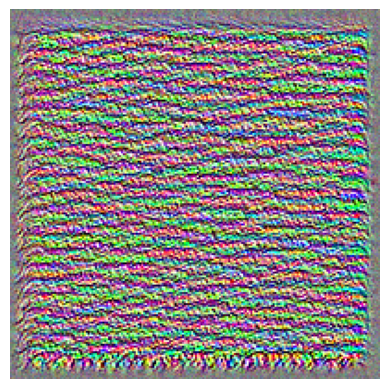

In [27]:
def deprocess_image(image):
	image -= image.mean()
	image /= image.std()
	image *= 64
	image += 128
	image = np.clip(image, 0, 255).astype("uint8")
	image = image[25:-25, 25:-25, :] #center crop to avoid border artifacts
	return image

plt.axis("off")
plt.imshow(generate_filter_pattern(2))
plt.show()





It seems that filter 0 in layer block3_sepconv1 is responsive to a horizontal lines pattern, somewhat water-like or fur-like. Now the fun part: you can start visualizing every filter in the layer, and even every filter in every layer in the model.

##  Listing 9.19 Generating a grid of all filter response patterns in a layer

In [29]:
all_images = []
for filter_index in range(64):
	print(f"Processing filter {filter_index}")
	image = deprocess_image(
		generate_filter_pattern(filter_index)
	)
	all_images.append(image)


margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

#Fill the picture with  the saved filters.
for i in range(n):
	for j in range(n):
		image = all_images[i * n + j]
		row_start = (cropped_width + margin) * i
		row_end = (cropped_width + margin) * i + cropped_width
		column_start = (cropped_height + margin) * j
		column_end = (cropped_height + margin) * j + cropped_height

		stitched_filters[
			row_start:row_end,
			column_start:column_end,
			:
		] = image

keras.utils.save_img(
	f"filters_for_{layer_name}.png",
	stitched_filters
)



Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

All 64 filters being processed in this code are from ONE LAYER - specifically the layer that was defined earlier in the notebook.

These filter visualizations (see figure 9.17) tell you a lot about how convnet layers see the world: each layer in a convnet learns a collection of filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as you go deeper in the model:

- The filters from the first layers in the model encode simple directional edges and colors (or colored edges, in some cases)

- The filters from layers a bit further up the stack, such as block4_sepconv1, encode simple textures made from combinations of edges and colors.

- The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.

## 9.4.3 Visualizing heatmaps of class activation

We’ll introduce one last visualization technique—one that is useful for understanding which parts of a given image led a convnet to its final classification decision.

This general category of techniques is called class activation map (CAM) visualization, and it consists of producing heatmaps of class activation over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration. For instance, given an image fed into a dogs-versus-cats convnet, CAM visualization would allow you to generate a heatmap for the class “cat,” indicating how cat-like different parts of the image are, and also a heatmap for the class “dog,” indicating how dog-like parts of the image are.

Grad-CAM consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel.

In [30]:
model = keras.applications.xception.Xception(
	weights="imagenet",
)

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Listing 9.21 Preprocessing an input image for Xception

In [31]:
img_path = keras.utils.get_file(
	"elephant.jpg",
	origin="https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

def get_img_array(img_path, target_size=(299, 299)):
	img = keras.utils.load_img(img_path, target_size=target_size)
	array = keras.utils.img_to_array(img)
	array = np.expand_dims(array, axis=0)
	return keras.applications.xception.preprocess_input(array)

img_array = get_img_array(img_path, target_size=(299, 299))




733657/733657 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [ ]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3) [0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
[('n02504458', 'African_elephant', np.float32(0.86993945)), ('n01871265', 'tusker', np.float32(0.07695635)), ('n02504013', 'Indian_elephant', np.float32(0.02354178))]


To visualize which parts of the image are the most African-elephant–like, let’s set up the Grad-CAM process.

 First, we create a model that maps the input image to the activations of the last convolutional layer.

In [33]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
	"avg_pool",
	"predictions"
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)


Second, we create a model that maps the activations of the last convolutional layer to the final class predictions.

In [34]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
	x = model.get_layer(layer_name) (x)

classifier_model = keras.Model(classifier_input, x)

Then we compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer.

In [35]:
import tensorflow as tf

with tf.GradientTape() as tape:
	#Compute activations of the last conv  layer and make the tape watch it.
	last_conv_layer_output = last_conv_layer_model(img_array)
	tape.watch(last_conv_layer_output)
	#retrieve the activation channel corresponding
	#to the top predicted class
	preds = classifier_model(last_conv_layer_output)
	top_pred_index = tf.argmax(preds[0])
	top_class_channel = preds[:, top_pred_index]

#This is the gradient of the top predicted class with regard
#to the output feature map of the last convolutional layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)


c:\Users\ryanz\estudo-ufal\dl\DeepLearningWithPython\env\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_166']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


Now we apply pooling and importance weighting to the gradient tensor to obtain our heatmap of class activation.

###  9.25 Gradient pooling and channel-importance weighting

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]

#multiply each channel in the output of the last conv layer by
# how important this channel is
for i in range(pooled_grads.shape[-1]):
	last_conv_layer_output[:, :, i] *= pooled_grads[i]
#The channel-wise mean of the resulting feature
# map is our heatmap of class activation.
heatmap = np.mean(last_conv_layer_output, axis=-1)

For visualization purposes, we’ll also normalize the heatmap between 0 and 1. The result is shown bellow

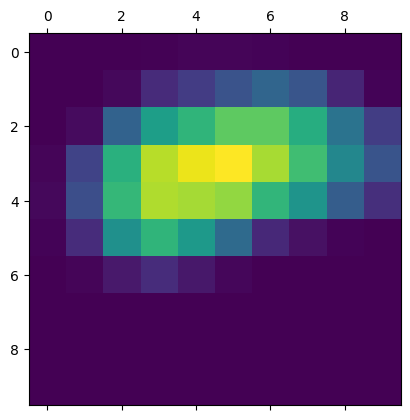

In [37]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Finally, let’s generate an image that superimposes the original image on the heatmap we just obtained

In [38]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(heatmap * 255)

#Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

#Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

#Create an image  that contains the  recolorized heatmap.
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

#Superimpose the  heatmap and the  original image,  with the heatmap  at 40% opacity.
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

print(f"saved at {save_path}")

saved at elephant_cam.jpg


C:\Users\ryanz\AppData\Local\Temp\ipykernel_21836\4007726995.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


### This visualization technique answers two important questions: 
- Why did the network think this image contained an African elephant?
- Where is the African elephant located in the picture?

## Summary
- There are three essential computer vision tasks you can do with deep learning: image classification, image segmentation, and object detection.
- Following modern convnet architecture best practices will help you get the most out of your models. Some of these best practices include using residual connections, batch normalization, and depthwise separable convolutions.
- The representations that convnets learn are easy to inspect—convnets are the opposite of black boxes!
- You can generate visualizations of the filters learned by your convnets, as well as heatmaps of class activity.